<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/CatBoast(_5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install catboost

In [65]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Step 1 Complete: All libraries imported successfully!")


✅ Step 1 Complete: All libraries imported successfully!


In [66]:

# =============================================================================
# STEP 2: LOAD THE DATASETS
# =============================================================================

def load_datasets():
    """Load train, validation, and test datasets"""
    print("Loading datasets...")

    try:
        # Load the three CSV files
        train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

        print(f"✅ Training set loaded: {train_df.shape}")
        print(f"✅ Validation set loaded: {val_df.shape}")
        print(f"✅ Test set loaded: {test_df.shape}")

        # Display basic info about the data
        print(f"\nDataset columns: {list(train_df.columns)}")
        print(f"Production range in training: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")

        return train_df, val_df, test_df

    except FileNotFoundError as e:
        print(f"❌ Error: Could not find CSV files. Make sure train.csv, validation.csv, and test.csv are in your working directory.")
        print(f"Error details: {e}")
        return None, None, None

# Run Step 2
train_df, val_df, test_df = load_datasets()


Loading datasets...
✅ Training set loaded: (3942, 84)
✅ Validation set loaded: (845, 84)
✅ Test set loaded: (845, 84)

Dataset columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'District_Faridpur', 'District_Feni', 'District_Gaiba

In [67]:

# =============================================================================
# STEP 3: CREATE QUANTILE-BASED LABELS
# =============================================================================

def create_production_labels(df, quantiles=None):
    """Create 5 quantile-based labels from production values"""
    df_copy = df.copy()
    production_col = 'Production (M.Ton)'

    # Calculate quantiles if not provided (use training data quantiles for all datasets)
    if quantiles is None:
        quantiles = np.quantile(df_copy[production_col], [0.2, 0.4, 0.6, 0.8])
        print(f"Quantile thresholds: {quantiles}")

    # Create labels based on quantiles
    def classify_production(value):
        if value <= quantiles[0]:
            return 0  # Very Low
        elif value <= quantiles[1]:
            return 1  # Low
        elif value <= quantiles[2]:
            return 2  # Medium
        elif value <= quantiles[3]:
            return 3  # High
        else:
            return 4  # Very High

    df_copy['Production_Label'] = df_copy[production_col].apply(classify_production)

    # Create label mapping for display
    label_mapping = {0: 'Very Low', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}

    print(f"Label distribution:")
    label_counts = df_copy['Production_Label'].value_counts().sort_index()
    for label, count in label_counts.items():
        print(f"  {label_mapping[label]}: {count} samples")

    return df_copy, quantiles

# Run Step 3
print("Creating labels for training set...")
train_df_labeled, training_quantiles = create_production_labels(train_df)

print("\nCreating labels for validation set...")
val_df_labeled, _ = create_production_labels(val_df, training_quantiles)

print("\nCreating labels for test set...")
test_df_labeled, _ = create_production_labels(test_df, training_quantiles)

print("✅ Step 3 Complete: Production labels created!")


Creating labels for training set...
Quantile thresholds: [ 578.    1463.    3119.524 6540.92 ]
Label distribution:
  Very Low: 793 samples
  Low: 786 samples
  Medium: 786 samples
  High: 788 samples
  Very High: 789 samples

Creating labels for validation set...
Label distribution:
  Very Low: 185 samples
  Low: 140 samples
  Medium: 191 samples
  High: 160 samples
  Very High: 169 samples

Creating labels for test set...
Label distribution:
  Very Low: 172 samples
  Low: 158 samples
  Medium: 167 samples
  High: 175 samples
  Very High: 173 samples
✅ Step 3 Complete: Production labels created!


In [68]:

# =============================================================================
# STEP 4: PREPARE FEATURES AND TARGET VARIABLES
# =============================================================================

def prepare_features_and_targets(train_df, val_df, test_df):
    """Prepare feature matrices and target vectors"""

    # Identify feature columns (exclude target and label columns)
    feature_cols = [col for col in train_df.columns
                   if col not in ['Production (M.Ton)', 'Production_Label']]

    print(f"Number of features: {len(feature_cols)}")
    print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10 features

    # Prepare training data
    X_train = train_df[feature_cols].copy()
    y_train = train_df['Production_Label'].values

    # Prepare validation data
    X_val = val_df[feature_cols].copy()
    y_val = val_df['Production_Label'].values

    # Prepare test data
    X_test = test_df[feature_cols].copy()
    y_test = test_df['Production_Label'].values

    # Handle missing values (fill with mean)
    print("Handling missing values...")
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())  # Use training mean for validation
    X_test = X_test.fillna(X_train.mean())  # Use training mean for test

    print(f"✅ Training features shape: {X_train.shape}")
    print(f"✅ Validation features shape: {X_val.shape}")
    print(f"✅ Test features shape: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

# Run Step 4
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = prepare_features_and_targets(
    train_df_labeled, val_df_labeled, test_df_labeled
)

print("✅ Step 4 Complete: Features and targets prepared!")


Number of features: 83
Feature columns: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)']...
Handling missing values...
✅ Training features shape: (3942, 83)
✅ Validation features shape: (845, 83)
✅ Test features shape: (845, 83)
✅ Step 4 Complete: Features and targets prepared!


In [69]:

# =============================================================================
# STEP 5: INITIALIZE AND TRAIN CATBOOST MODEL
# =============================================================================

def train_catboost_model(X_train, y_train, X_val, y_val, iterations=100):
    """Train CatBoost classifier with specified parameters"""

    print(f"Initializing CatBoost model with {iterations} iterations...")

    # Initialize CatBoost Classifier
    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        random_seed=42,
        verbose=100,  # Print progress every 100 iterations
        early_stopping_rounds=50,
        use_best_model=True
    )

    print("Starting model training...")
    print("This may take a few minutes depending on your data size and iterations...")

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        plot=False,
        verbose=True
    )

    print("✅ Model training completed!")

    # Get training history
    evals_result = model.get_evals_result()
    val_accuracies = evals_result['validation']['Accuracy']

    print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
    print(f"Best iteration: {model.get_best_iteration()}")

    return model, val_accuracies

# Run Step 5
print("=" * 50)
print("STARTING MODEL TRAINING")
print("=" * 50)

catboost_model, validation_accuracies = train_catboost_model(
    X_train, y_train, X_val, y_val, iterations=1000
)


STARTING MODEL TRAINING
Initializing CatBoost model with 1000 iterations...
Starting model training...
This may take a few minutes depending on your data size and iterations...
0:	learn: 0.5707763	test: 0.5609467	best: 0.5609467 (0)	total: 80.4ms	remaining: 1m 20s
1:	learn: 0.6093354	test: 0.6059172	best: 0.6059172 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 0.6265855	test: 0.6272189	best: 0.6272189 (2)	total: 191ms	remaining: 1m 3s
3:	learn: 0.6468798	test: 0.6485207	best: 0.6485207 (3)	total: 214ms	remaining: 53.3s
4:	learn: 0.6560122	test: 0.6532544	best: 0.6532544 (4)	total: 234ms	remaining: 46.5s
5:	learn: 0.6704718	test: 0.6662722	best: 0.6662722 (5)	total: 255ms	remaining: 42.3s
6:	learn: 0.6778285	test: 0.6674556	best: 0.6674556 (6)	total: 286ms	remaining: 40.6s
7:	learn: 0.6801116	test: 0.6804734	best: 0.6804734 (7)	total: 314ms	remaining: 39s
8:	learn: 0.6803653	test: 0.6781065	best: 0.6804734 (7)	total: 343ms	remaining: 37.7s
9:	learn: 0.6854389	test: 0.6852071	best: 0.6852

In [70]:

# =============================================================================
# STEP 6: DEFINE EVALUATION FUNCTIONS
# =============================================================================

def calculate_metrics(y_true, y_pred):
    """Calculate all required metrics"""

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

def print_detailed_results(metrics, dataset_name):
    """Print detailed evaluation results"""
    print(f"\n{'='*20} {dataset_name.upper()} RESULTS {'='*20}")
    print(f"Accuracy:                 {metrics['accuracy']:.4f}")
    print(f"Precision (Macro):        {metrics['precision_macro']:.4f}")
    print(f"Precision (Weighted):     {metrics['precision_weighted']:.4f}")
    print(f"Recall (Macro):           {metrics['recall_macro']:.4f}")
    print(f"Recall (Weighted):        {metrics['recall_weighted']:.4f}")
    print(f"F1 Score (Macro):         {metrics['f1_macro']:.4f}")
    print(f"F1 Score (Weighted):      {metrics['f1_weighted']:.4f}")
    print("=" * (42 + len(dataset_name)))


In [71]:

# =============================================================================
# STEP 7: EVALUATE ON VALIDATION SET
# =============================================================================

print("\n" + "=" * 50)
print("EVALUATING ON VALIDATION SET")
print("=" * 50)

# Make predictions on validation set
y_val_pred = catboost_model.predict(X_val)

# Calculate metrics
val_metrics = calculate_metrics(y_val, y_val_pred)

# Print results
print_detailed_results(val_metrics, "VALIDATION")

# Print classification report
class_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
print(f"\nDetailed Classification Report - Validation Set:")
print(classification_report(y_val, y_val_pred, target_names=class_labels, zero_division=0))



EVALUATING ON VALIDATION SET

==================== VALIDATION RESULTS ====================
Accuracy:                 0.8497
Precision (Macro):        0.8475
Precision (Weighted):     0.8517
Recall (Macro):           0.8480
Recall (Weighted):        0.8497
F1 Score (Macro):         0.8475
F1 Score (Weighted):      0.8505

Detailed Classification Report - Validation Set:
              precision    recall  f1-score   support

    Very Low       0.96      0.94      0.95       185
         Low       0.79      0.84      0.82       140
      Medium       0.82      0.81      0.81       191
        High       0.75      0.77      0.76       160
   Very High       0.91      0.88      0.90       169

    accuracy                           0.85       845
   macro avg       0.85      0.85      0.85       845
weighted avg       0.85      0.85      0.85       845



In [72]:

# =============================================================================
# STEP 8: EVALUATE ON TEST SET
# =============================================================================

print("\n" + "=" * 50)
print("EVALUATING ON TEST SET")
print("=" * 50)

# Make predictions on test set
y_test_pred = catboost_model.predict(X_test)

# Calculate metrics
test_metrics = calculate_metrics(y_test, y_test_pred)

# Print results
print_detailed_results(test_metrics, "TEST")

# Print classification report
print(f"\nDetailed Classification Report - Test Set:")
print(classification_report(y_test, y_test_pred, target_names=class_labels, zero_division=0))



EVALUATING ON TEST SET

==================== TEST RESULTS ====================
Accuracy:                 0.8391
Precision (Macro):        0.8415
Precision (Weighted):     0.8427
Recall (Macro):           0.8381
Recall (Weighted):        0.8391
F1 Score (Macro):         0.8393
F1 Score (Weighted):      0.8404

Detailed Classification Report - Test Set:
              precision    recall  f1-score   support

    Very Low       0.93      0.91      0.92       172
         Low       0.79      0.80      0.79       158
      Medium       0.76      0.78      0.77       167
        High       0.77      0.82      0.80       175
   Very High       0.95      0.88      0.91       173

    accuracy                           0.84       845
   macro avg       0.84      0.84      0.84       845
weighted avg       0.84      0.84      0.84       845




PLOTTING CONFUSION MATRICES
Plotting Validation Confusion Matrix...


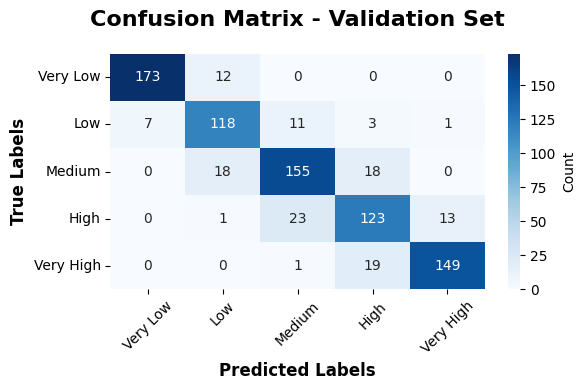

Plotting Test Confusion Matrix...


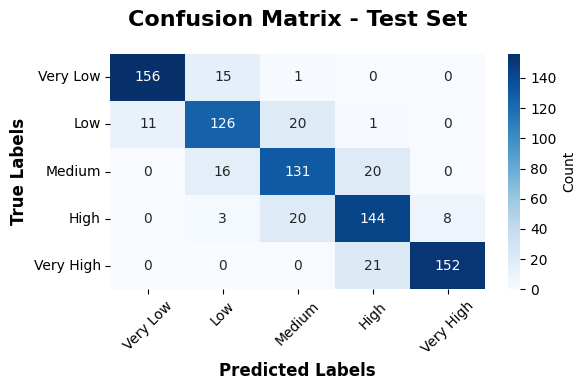

In [73]:

# =============================================================================
# STEP 9: PLOT CONFUSION MATRICES
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, dataset_name, class_labels):
    """Plot confusion matrix"""
    plt.figure(figsize=(6, 4))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_labels,
               yticklabels=class_labels,
               cbar_kws={'label': 'Count'})

    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    plt.ylabel('True Labels', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

print("\n" + "=" * 50)
print("PLOTTING CONFUSION MATRICES")
print("=" * 50)

# Plot validation confusion matrix
print("Plotting Validation Confusion Matrix...")
val_cm = plot_confusion_matrix(y_val, y_val_pred, "Validation", class_labels)

# Plot test confusion matrix
print("Plotting Test Confusion Matrix...")
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Test", class_labels)



PLOTTING TRAINING HISTORY AND FEATURE IMPORTANCE


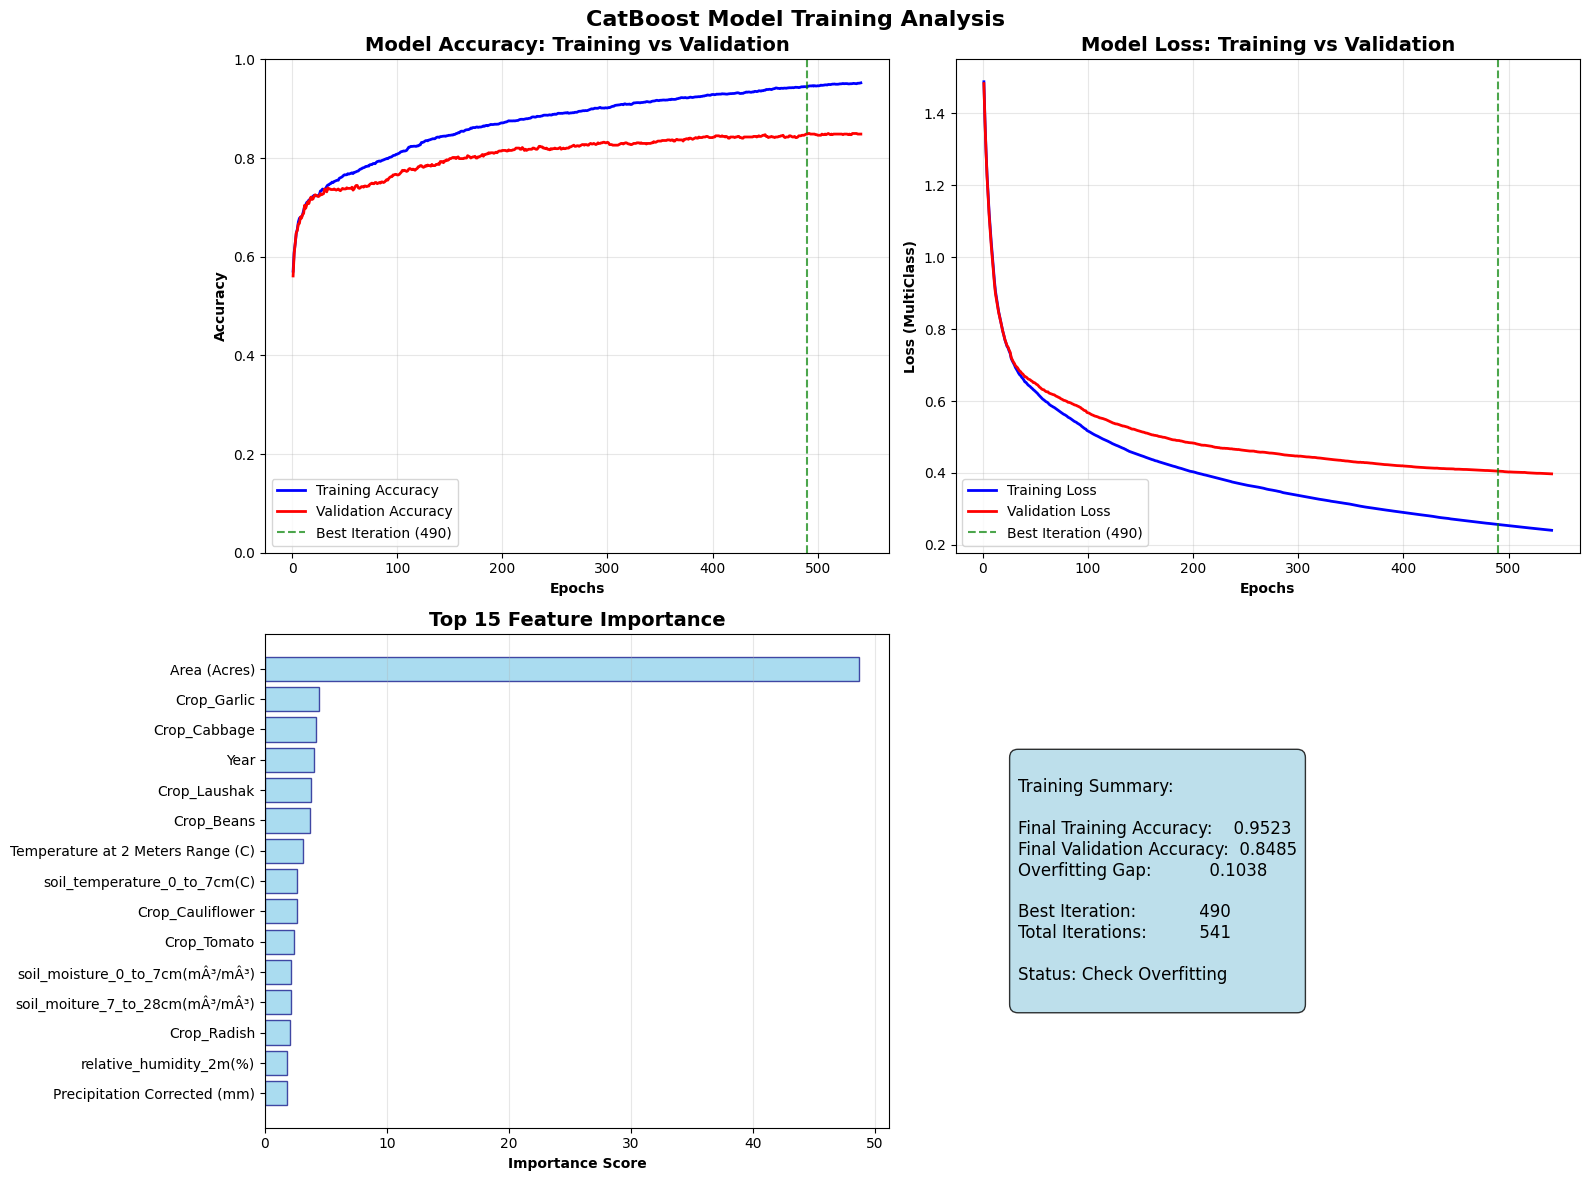

In [74]:
# =============================================================================
# STEP 10: PLOT TRAINING HISTORY AND FEATURE IMPORTANCE (ENHANCED)
# =============================================================================

def plot_training_and_features(model, feature_names):
    """Plot training history with both train/val metrics and feature importance"""

    # Get training history from CatBoost model
    evals_result = model.get_evals_result()

    # Extract metrics
    train_accuracies = evals_result['learn']['Accuracy']
    val_accuracies = evals_result['validation']['Accuracy']

    # Try to get loss data (MultiClass loss)
    train_loss = evals_result['learn'].get('MultiClass', [])
    val_loss = evals_result['validation'].get('MultiClass', [])

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('CatBoost Model Training Analysis', fontsize=16, fontweight='bold')

    epochs = list(range(1, len(train_accuracies) + 1))
    best_iter = model.get_best_iteration()

    # Plot 1: Training vs Validation Accuracy
    axes[0, 0].plot(epochs, train_accuracies, 'b-', linewidth=2, label='Training Accuracy')
    axes[0, 0].plot(epochs, val_accuracies, 'r-', linewidth=2, label='Validation Accuracy')
    axes[0, 0].axvline(x=best_iter, color='green', linestyle='--', alpha=0.7,
                      label=f'Best Iteration ({best_iter})')
    axes[0, 0].set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])

    # Plot 2: Training vs Validation Loss
    if train_loss and val_loss:
        axes[0, 1].plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
        axes[0, 1].plot(epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')
        axes[0, 1].axvline(x=best_iter, color='green', linestyle='--', alpha=0.7,
                          label=f'Best Iteration ({best_iter})')
        axes[0, 1].set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epochs', fontweight='bold')
        axes[0, 1].set_ylabel('Loss (MultiClass)', fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        # Fallback: show validation accuracy with more detail
        axes[0, 1].plot(epochs, val_accuracies, 'r-', linewidth=2, label='Validation Accuracy')
        axes[0, 1].set_title('Validation Accuracy (Detailed)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epochs', fontweight='bold')
        axes[0, 1].set_ylabel('Accuracy', fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Feature Importance
    feature_importance = model.get_feature_importance()
    top_indices = np.argsort(feature_importance)[-15:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    y_pos = np.arange(len(top_features))
    axes[1, 0].barh(y_pos, top_importance, color='skyblue', edgecolor='navy', alpha=0.7)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(top_features, fontsize=10)
    axes[1, 0].set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Importance Score', fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Plot 4: Training Summary
    axes[1, 1].axis('off')

    # Summary statistics
    final_train_acc = train_accuracies[-1]
    final_val_acc = val_accuracies[-1]
    overfitting_gap = final_train_acc - final_val_acc

    summary_text = f"""
Training Summary:

Final Training Accuracy:    {final_train_acc:.4f}
Final Validation Accuracy:  {final_val_acc:.4f}
Overfitting Gap:           {overfitting_gap:.4f}

Best Iteration:            {best_iter}
Total Iterations:          {len(epochs)}

Status: {'Good Fit' if abs(overfitting_gap) < 0.1 else 'Check Overfitting'}
"""

    axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 50)
print("PLOTTING TRAINING HISTORY AND FEATURE IMPORTANCE")
print("=" * 50)

# Replace the original function call with this enhanced version
plot_training_and_features(catboost_model, feature_names)

In [75]:

# =============================================================================
# STEP 11: FINAL SUMMARY AND COMPARISON
# =============================================================================

def create_final_summary(val_metrics, test_metrics):
    """Create final summary comparison"""

    print("\n" + "=" * 70)
    print("FINAL RESULTS SUMMARY")
    print("=" * 70)

    # Create comparison DataFrame
    comparison_data = {
        'Validation Set': [
            f"{val_metrics['accuracy']:.4f}",
            f"{val_metrics['precision_macro']:.4f}",
            f"{val_metrics['recall_macro']:.4f}",
            f"{val_metrics['f1_macro']:.4f}",
            f"{val_metrics['f1_weighted']:.4f}"
        ],
        'Test Set': [
            f"{test_metrics['accuracy']:.4f}",
            f"{test_metrics['precision_macro']:.4f}",
            f"{test_metrics['recall_macro']:.4f}",
            f"{test_metrics['f1_macro']:.4f}",
            f"{test_metrics['f1_weighted']:.4f}"
        ],
        'Difference': [
            f"{abs(val_metrics['accuracy'] - test_metrics['accuracy']):.4f}",
            f"{abs(val_metrics['precision_macro'] - test_metrics['precision_macro']):.4f}",
            f"{abs(val_metrics['recall_macro'] - test_metrics['recall_macro']):.4f}",
            f"{abs(val_metrics['f1_macro'] - test_metrics['f1_macro']):.4f}",
            f"{abs(val_metrics['f1_weighted'] - test_metrics['f1_weighted']):.4f}"
        ]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                index=['Accuracy', 'Precision (Macro)', 'Recall (Macro)',
                                      'F1 Score (Macro)', 'F1 Score (Weighted)'])

    print(comparison_df)
    print("=" * 70)

    # Highlight key metrics
    print(f"\n🎯 KEY PERFORMANCE INDICATORS:")
    print(f"   • Validation Macro F1 Score: {val_metrics['f1_macro']:.4f}")
    print(f"   • Test Macro F1 Score:       {test_metrics['f1_macro']:.4f}")
    print(f"   • Model Generalization:      {'Good' if abs(val_metrics['f1_macro'] - test_metrics['f1_macro']) < 0.05 else 'Moderate'}")

    return comparison_df

# Run Step 11
final_summary = create_final_summary(val_metrics, test_metrics)

print("\n🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("\n📊 All metrics have been calculated and visualized.")
print("📈 Check the plots above for detailed analysis.")


FINAL RESULTS SUMMARY
                    Validation Set Test Set Difference
Accuracy                    0.8497   0.8391     0.0107
Precision (Macro)           0.8475   0.8415     0.0060
Recall (Macro)              0.8480   0.8381     0.0099
F1 Score (Macro)            0.8475   0.8393     0.0082
F1 Score (Weighted)         0.8505   0.8404     0.0101

🎯 KEY PERFORMANCE INDICATORS:
   • Validation Macro F1 Score: 0.8475
   • Test Macro F1 Score:       0.8393
   • Model Generalization:      Good

🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!

📊 All metrics have been calculated and visualized.
📈 Check the plots above for detailed analysis.
